In [1]:
import re
from queue import Queue
from typing import Iterable
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ete3
from ete3 import PhyloTree
from scipy.stats import entropy

from Bio.Data import CodonTable

In [2]:
path_to_tree =   "../data/interim/iqtree_runs/brun3/anc_kg/anc_kg.treefile"
path_to_states = "../data/interim/iqtree_runs/brun3/anc_kg/anc_kg.state"
path_to_leaves = "../data/interim/leaves_states.tsv"

In [3]:
!ls ../data/interim/iqtree_runs/brun3/anc_kg/

anc_kg.ckp.gz  anc_kg.iqtree  anc_kg.log  anc_kg.state	anc_kg.treefile


In [4]:
tree = tree = PhyloTree(path_to_tree, format=1)

In [5]:
tree.describe()

Number of leaf nodes:	764
Total number of nodes:	1526
Rooted:	No
Most distant node:	Crypturellus_undulatus
Max. distance:	0.447375


In [6]:
# print(tree.get_ascii())
# tree.show()

In [7]:
adtype = {
    "Site": np.int32,
    "p_A":  np.float32,
    "p_C":  np.float32,
    "p_G":  np.float32,
    "p_T":  np.float32
}
anc = pd.read_csv(path_to_states, sep="\t", comment='#', dtype=adtype)


In [9]:
anc.groupby("Node").apply(len)

Node
Node1      11325
Node10     11325
Node100    11325
Node101    11325
Node102    11325
           ...  
Node95     11325
Node96     11325
Node97     11325
Node98     11325
Node99     11325
Length: 762, dtype: int64

In [21]:
anc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8629650 entries, 0 to 8629649
Data columns (total 7 columns):
 #   Column  Dtype  
---  ------  -----  
 0   Node    object 
 1   Site    int32  
 2   State   object 
 3   p_A     float32
 4   p_C     float32
 5   p_G     float32
 6   p_T     float32
dtypes: float32(4), int32(1), object(2)
memory usage: 296.3+ MB


In [13]:
anc.shape, anc[anc.Node == "Node1"].shape

(8629650, 7)

In [15]:
anc[anc.Node == "Node1"].head()

,Node,Site,State,p_A,p_C,p_G,p_T
8618325,Node1,1,A,0.96190,0.00923,0.02219,0.00668
8618326,Node1,2,T,0.00800,0.05699,0.00347,0.93154
8618327,Node1,3,G,0.04505,0.00893,0.93955,0.00646
8618328,Node1,4,A,0.99358,0.00052,0.00553,0.00037
8618329,Node1,5,A,0.83463,0.03430,0.01926,0.11182


In [18]:
anc.Node.str.startswith("Node").sum() == anc.shape[0]

True

In [6]:
anc = pd.read_csv(path_to_states, sep="\t", comment='#',)
leaves = pd.read_csv(path_to_leaves, sep="\t")

states = pd.concat([anc, leaves]).sort_values(["Node", "Part", "Site"])
print(states.shape)
states.head()

(2866578, 8)


,Node,Part,Site,State,p_A,p_C,p_G,p_T
6516,Acanthocheilonema_viteae,1,1,A,1.0,0.0,0.0,0.0
6517,Acanthocheilonema_viteae,1,2,T,0.0,0.0,0.0,1.0
6518,Acanthocheilonema_viteae,1,3,T,0.0,0.0,0.0,1.0
6519,Acanthocheilonema_viteae,1,4,T,0.0,0.0,0.0,1.0
6520,Acanthocheilonema_viteae,1,5,T,0.0,0.0,0.0,1.0


In [7]:
anc[anc.Node == "Node6"]

,Node,Part,Site,State,p_A,p_C,p_G,p_T
0,Node6,1,1,T,0.03012,0.00375,0.00625,0.95988
1,Node6,1,2,T,0.00001,0.00006,0.00000,0.99993
2,Node6,1,3,G,0.30508,0.02994,0.53229,0.13270
3,Node6,1,4,T,0.00953,0.30213,0.02986,0.65848
4,Node6,1,5,A,0.54912,0.00212,0.40747,0.04130
...,...,...,...,...,...,...,...,...
10018,Node6,5,2936,T,0.00041,0.00338,0.00014,0.99606
10019,Node6,5,2937,T,0.11066,0.06397,0.06969,0.75568
10020,Node6,5,2938,T,0.09209,0.06654,0.06031,0.78106
10021,Node6,5,2939,T,0.00006,0.00063,0.00002,0.99929


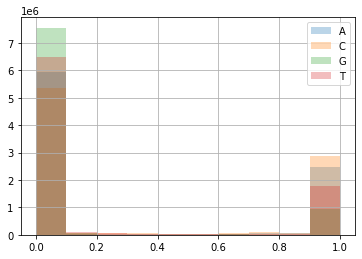

In [22]:
anc.p_A.hist(alpha=.3, label="A")
anc.p_C.hist(alpha=.3, label="C")
anc.p_G.hist(alpha=.3, label="G")
anc.p_T.hist(alpha=.3, label="T")
plt.legend()

## 10% of positions are uncertain

In [23]:
np.any(anc[["p_A", "p_C", "p_G", "p_T"]] > 0.8, 1).value_counts(normalize=True)

True     0.953422
False    0.046578
dtype: float64

In [34]:
mentr = entropy(anc[["p_A", "p_C", "p_G", "p_T"]].values, axis=1)

Text(0.5, 1.0, 'Entropy')

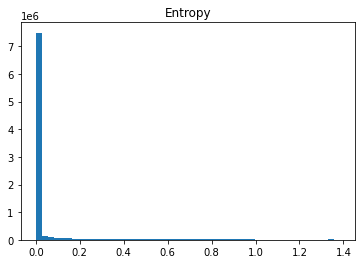

In [36]:
plt.hist(mentr, bins=50)
plt.title("Entropy")

<AxesSubplot:>

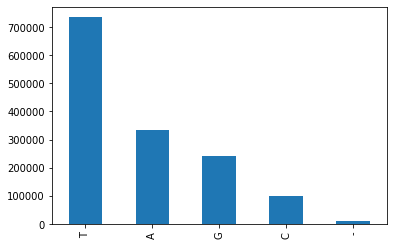

In [15]:
anc.State.value_counts().plot.bar()

## MUTSPEC

In [9]:
mutations = pd.read_csv("../data/processed/nematoda_mutations.csv")
edge_mutspec_all = pd.read_csv("../data/processed/nematoda_mutspec_all.csv")
edge_mutspec_syn = pd.read_csv("../data/processed/nematoda_mutspec_syn.csv")
edge_mutspec_ff = pd.read_csv("../data/processed/nematoda_mutspec_ff.csv")

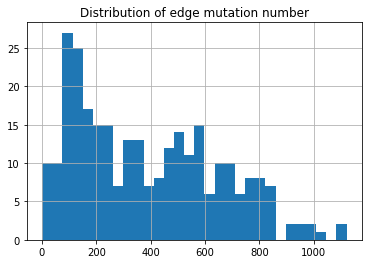

In [10]:
mutations.groupby("AltNode").apply(len).hist(bins=30)
plt.title("Distribution of edge mutation number");

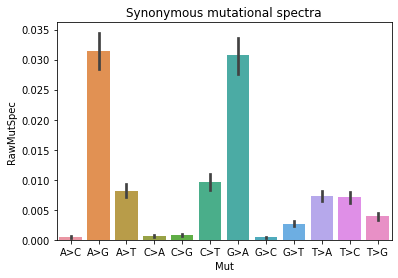

In [11]:
sns.barplot(x="Mut", y="RawMutSpec", data=edge_mutspec_syn, order=sorted(edge_mutspec_syn.Mut.unique()));
plt.title("Synonymous mutational spectra")
plt.savefig("../figures/nematoda_mutspec_syn.svg")
plt.show()

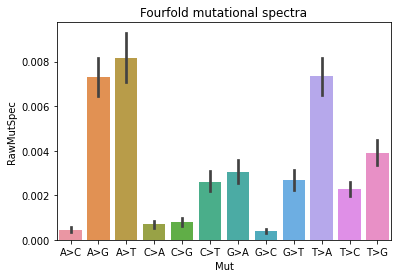

In [12]:
sns.barplot(x="Mut", y="RawMutSpec", data=edge_mutspec_ff, order=sorted(edge_mutspec_ff.Mut.unique()));
plt.title("Fourfold mutational spectra")
plt.savefig("../figures/nematoda_mutspec_ff.svg")
plt.show()

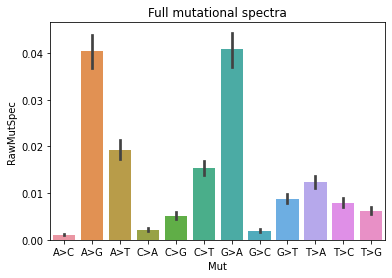

In [13]:
sns.barplot(x="Mut", y="RawMutSpec", data=edge_mutspec_all, order=sorted(edge_mutspec_all.Mut.unique()));
plt.title("Full mutational spectra")
plt.savefig("../figures/nematoda_mutspec_all.svg")
plt.show()

In [14]:
def prepare_one_mut_share_file(mutspec: pd.DataFrame, filename: str, sbs="C>T"):
    assert bool(re.match("[ACGT]>[ACGT]", sbs)), "sbs is not appropriate"
    cols = ["RefNode", "AltNode", "MutSpec"]
    for c in cols:
        assert c in mutspec, f"Column {c} is not in mutspec dataframe"
    
    shares = mutspec[mutspec.Mut == sbs][cols]
    shares.to_csv(filename, "\t", index=None)
    return shares


In [27]:
pref_sbs = "C>T"
prepare_one_mut_share_file(edge_mutspec, "../data/processed/c2t_edge_mutspec.tsv")

<AxesSubplot:>

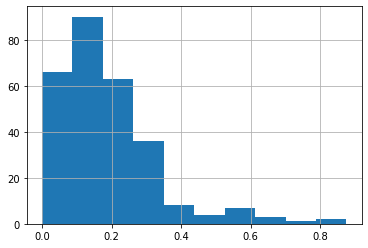

In [23]:
edge_mutspec_ff[edge_mutspec_ff.Mut == "A>G"]["MutSpec"].hist()